In [143]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


# Data

The data sets are already standardized with the `data/clean01.py` and `data/clean02.py` scripts so
whichever operation we can do on one data set, we can do on the other.

Genshin Impact, being the wonderful game that it is, has decided that it is going to have three types
of banners players can pull from. Thus, I am going to analyze them separately because _I do be eager
like that_.


## Data Format

I am going to skip the format of the original data set because it is irrelevant to this notebook.

The rows of the data sets are as following:

- **Rarity**: how many stars the character/weapon is classified as
- **Date**: date of the pull
- **Time**: time of the pull
- **Banner**: type of banner, described as following:
  - _200_: Permanent banner, always available to players
  - _301_ and _400_: Limited character banner, changes every now and then
  - _302_: Limited weapon banner, changes every now and then
- **Type**: drop type, either character or weapon
  - This attribute might interfere with our model so it might be dropped later on


In [144]:
from datetime import date, timedelta


def simplify_dt(given_dt: str):
    given_date, given_time = given_dt.split(' ')
    yr, mo, da = map(int, given_date.split('-'))
    hr, mi, _ = map(int, given_time.split(':'))

    pull_time = hr + round(mi / 60)
    pull_date = date(yr, mo, da) + timedelta(pull_time // 24)

    return (pull_date, pull_time % 24)


data_set01 = pd.read_csv("data/data01.csv")
data_set02 = pd.read_csv("data/data02.csv")
full_df = pd.concat([data_set01, data_set02]).reset_index().drop(
    ["Type", "index"], axis=1)
full_df["DateTime"] = full_df["DateTime"].apply(simplify_dt)

full_df.sample(5)


,Rarity,DateTime,Banner
4365396,3,"(2021-11-14, 15)",200
1449449,3,"(2022-04-23, 16)",301
3428161,4,"(2022-02-16, 11)",301
4285380,3,"(2022-01-25, 20)",301
4818264,3,"(2021-12-04, 7)",302


# Reusable Code for Analysis

These are just some constants and functions used for analyzing the data.


## Constants


In [145]:
RELEASE_DATE = date(2020, 9, 28)
time_since_release = (date.today() - RELEASE_DATE)
days_since_release = time_since_release.days
months_since_release = days_since_release // 30


## Functions used to transform the data


In [146]:
def transform_rarity(banner: pd.DataFrame, cond_series: pd.Series, dimension: tuple[int, int]):
    grouped_counts = banner[cond_series]\
        .groupby("DateTime")\
        .count()

    ret_matrix = np.zeros(dimension)
    for i, key in enumerate(grouped_counts.index):
        d, t = key
        ret_matrix[t, d] = grouped_counts.iloc[i]

    return ret_matrix


def transform_func(banner: pd.DataFrame, date_transformer: callable, dimension: tuple[int, int]) -> list[np.ndarray]:
    banner = banner.drop("Banner", axis=1)
    banner["DateTime"] = banner["DateTime"].map(date_transformer)

    total = transform_rarity(banner, banner.Rarity != 0, dimension)
    five_stars = transform_rarity(banner, banner.Rarity == 5, dimension)
    four_stars = transform_rarity(banner, banner.Rarity == 4, dimension)

    return [total, five_stars / (total + 1), four_stars / (total + 1)]


def first_doy(d): return date(d.year, 1, 1)


def dow_transformer(dt): return (dt[0].weekday(), dt[1])
def dom_transformer(dt): return (dt[0].day - 1, dt[1])
def doy_transformer(dt): return ((first_doy(dt[0]) - dt[0]).days, dt[1])
def dsr_transformer(dt): return ((dt[0] - RELEASE_DATE).days, dt[1])


## Visualization Helpers, yoinked from Matplotlib's website


In [147]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", set_ticks=True, **kwargs):
    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    im = ax.imshow(data, cmap="gray", **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.spines[:].set_visible(False)

    if set_ticks:
        ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
        ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


## Functions used to visualize the data


In [148]:
def dow_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str, title: str):
    row_label = np.arange(0, 24)
    col_label = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    heatmap(data, row_label, col_label, ax, cbarlabel=bar_label)
    ax.set_title(title)


def dom_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str, title: str):
    row_label = np.arange(0, 24)
    col_label = np.arange(1, 32)
    heatmap(data, row_label, col_label, ax, cbarlabel=bar_label)
    ax.set_title(title)


def doy_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str):
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    split_data = np.hsplit(data, np.cumsum(days_in_months))
    row_label = np.arange(0, 24)

    d_min = np.min(data)
    d_max = np.max(data)

    rows, cols = ax.shape
    for i in range(rows):
        for j in range(cols):
            idx_1d = i * rows + j
            split_col = np.arange(1, days_in_months[idx_1d] + 1)
            heatmap(split_data[idx_1d], row_label, split_col, ax[i, j], cbarlabel=bar_label,
                    set_ticks=False, vmin=d_min, vmax=d_max)
            ax[i, j].set_title(months[idx_1d])


def dsr_heatmap(data: np.ndarray, ax: plt.Axes, bar_label: str):
    months = [f"Month {i + 1}" for i in range(ax.size)]
    data = data[:, :30 * (data.shape[1] // 30 - 1)]
    split_data = np.hsplit(data, 30)
    row_label = np.arange(0, 24)

    d_min = np.min(data)
    d_max = np.max(data)

    rows, cols = ax.shape
    for i in range(rows):
        for j in range(cols):
            idx_1d = i * rows + j
            split_col = np.arange(1, 31)
            heatmap(split_data[idx_1d], row_label, split_col, ax[i, j], cbarlabel=bar_label,
                    set_ticks=False, vmin=d_min, vmax=d_max)
            ax[i, j].set_title(months[idx_1d])


# First Try: _Raw Data_


## Day of the Week


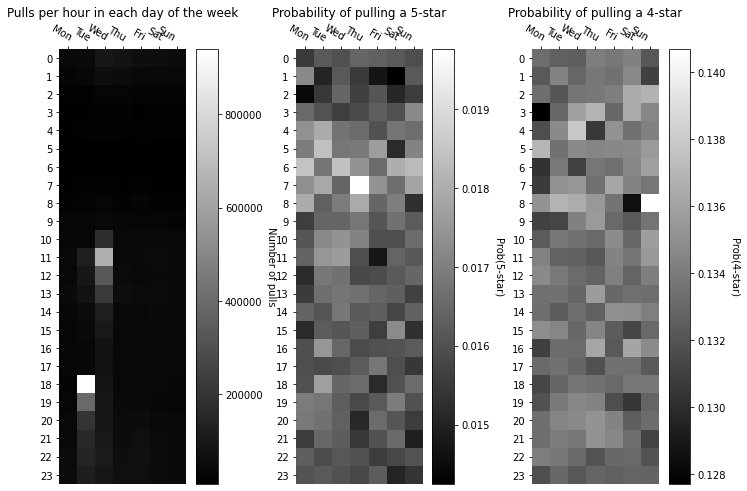

In [149]:
total_dow = transform_func(full_df, dow_transformer, (24, 7))
all_total, all_fives, all_fours = total_dow
_, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 8))

dow_heatmap(all_total, ax1, "Number of pulls",
            "Pulls per hour in each day of the week")
dow_heatmap(all_fives, ax2, "Prob(5-star)", "Probability of pulling a 5-star")
dow_heatmap(all_fours, ax3, "Prob(4-star)", "Probability of pulling a 4-star")

plt.show()


## Day of Month


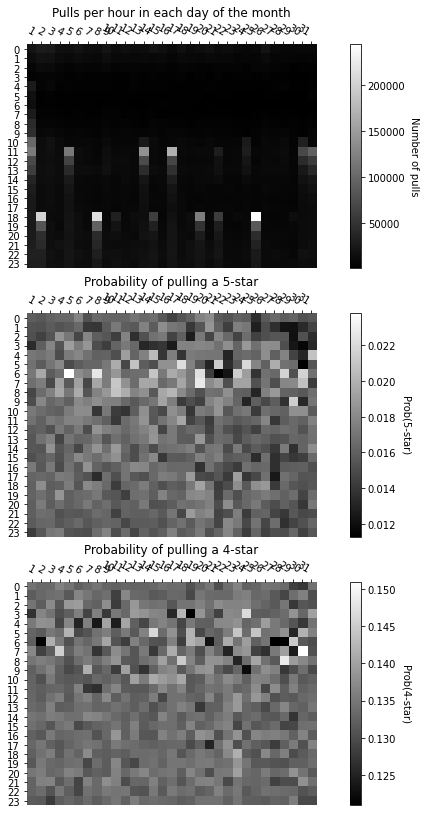

In [159]:
total_dom = transform_func(full_df, dom_transformer, (24, 31))
all_dom, all_fives, all_fours = total_dom
_, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 14))

dom_heatmap(all_dom, ax1, "Number of pulls",
            "Pulls per hour in each day of the month")
dom_heatmap(all_fives, ax2, "Prob(5-star)", "Probability of pulling a 5-star")
dom_heatmap(all_fours, ax3, "Prob(4-star)", "Probability of pulling a 4-star")


## Day of Year (by month)


In [151]:
total_doy = transform_func(full_df, doy_transformer, (24, 365))
all_total, all_fives, all_fours = total_doy


### Pulls


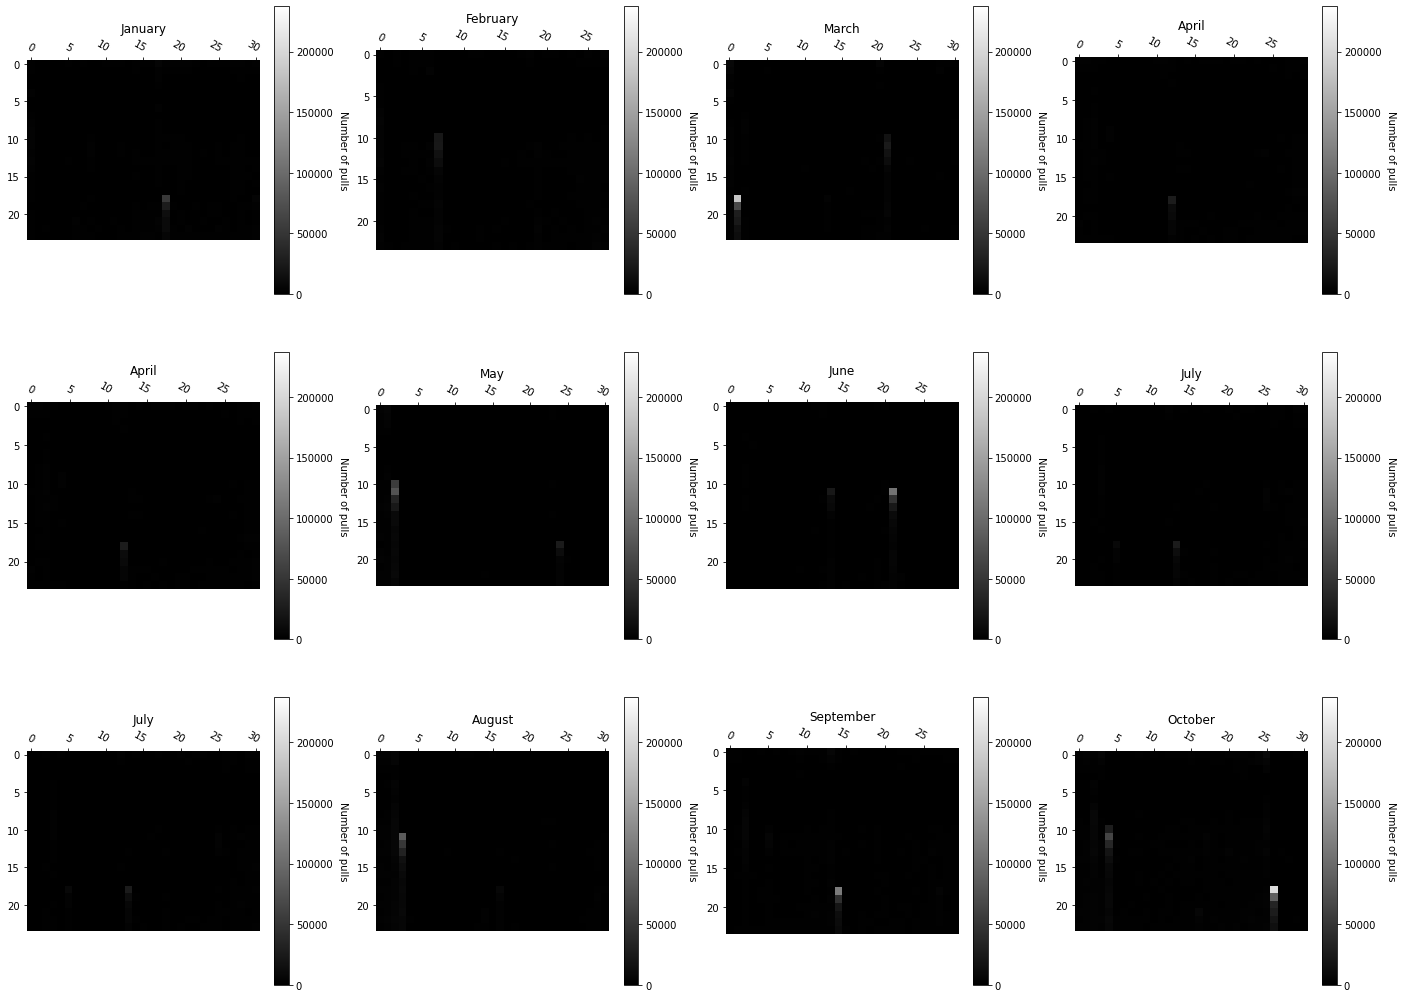

In [152]:
_, ax = plt.subplots(3, 4, figsize=(24, 18))
doy_heatmap(all_total, ax, "Number of pulls")


### 5-star


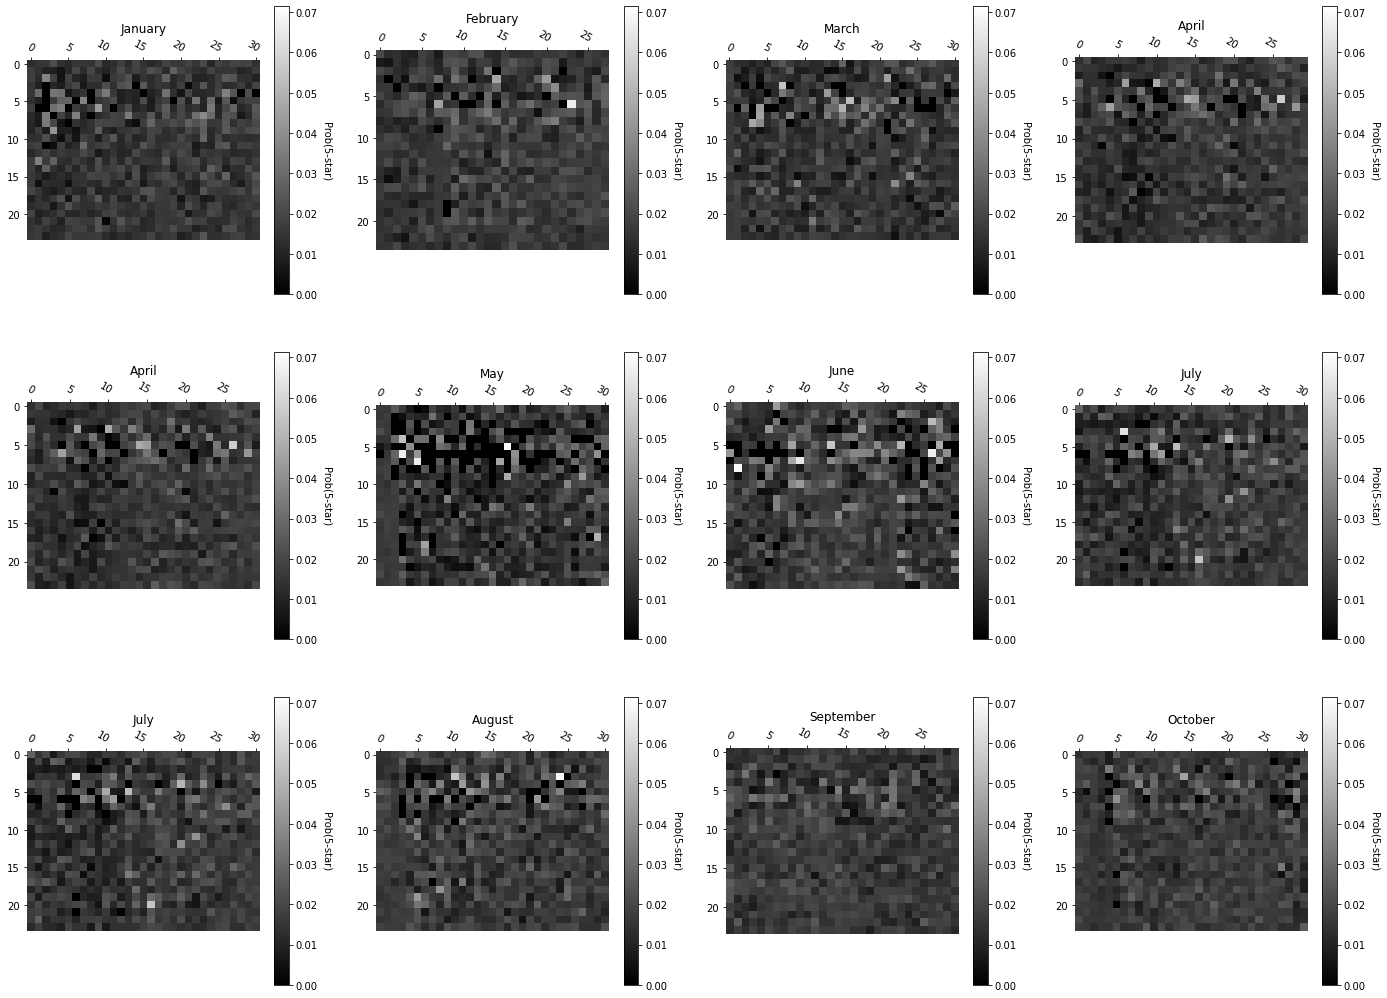

In [153]:
_, ax = plt.subplots(3, 4, figsize=(24, 18))
doy_heatmap(all_fives, ax, "Prob(5-star)")


### 4-star


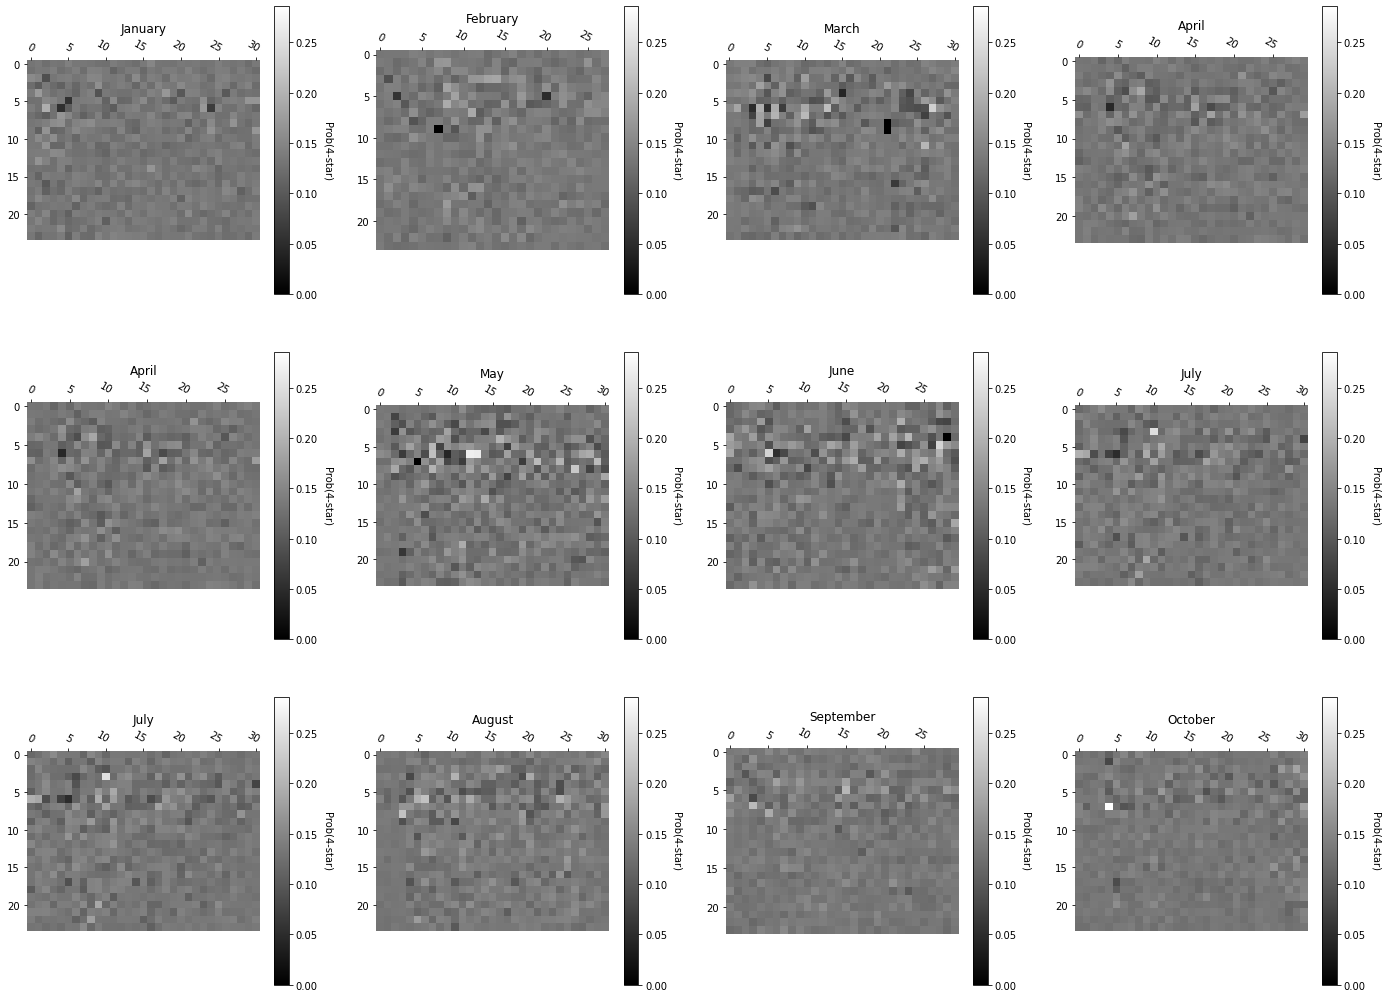

In [154]:
_, ax = plt.subplots(3, 4, figsize=(24, 18))
doy_heatmap(all_fours, ax, "Prob(4-star)")


## Days since release


In [155]:
total_dsr = transform_func(full_df, dsr_transformer, (24, days_since_release))
all_total, all_fives, all_fours = total_dsr


### Pulls


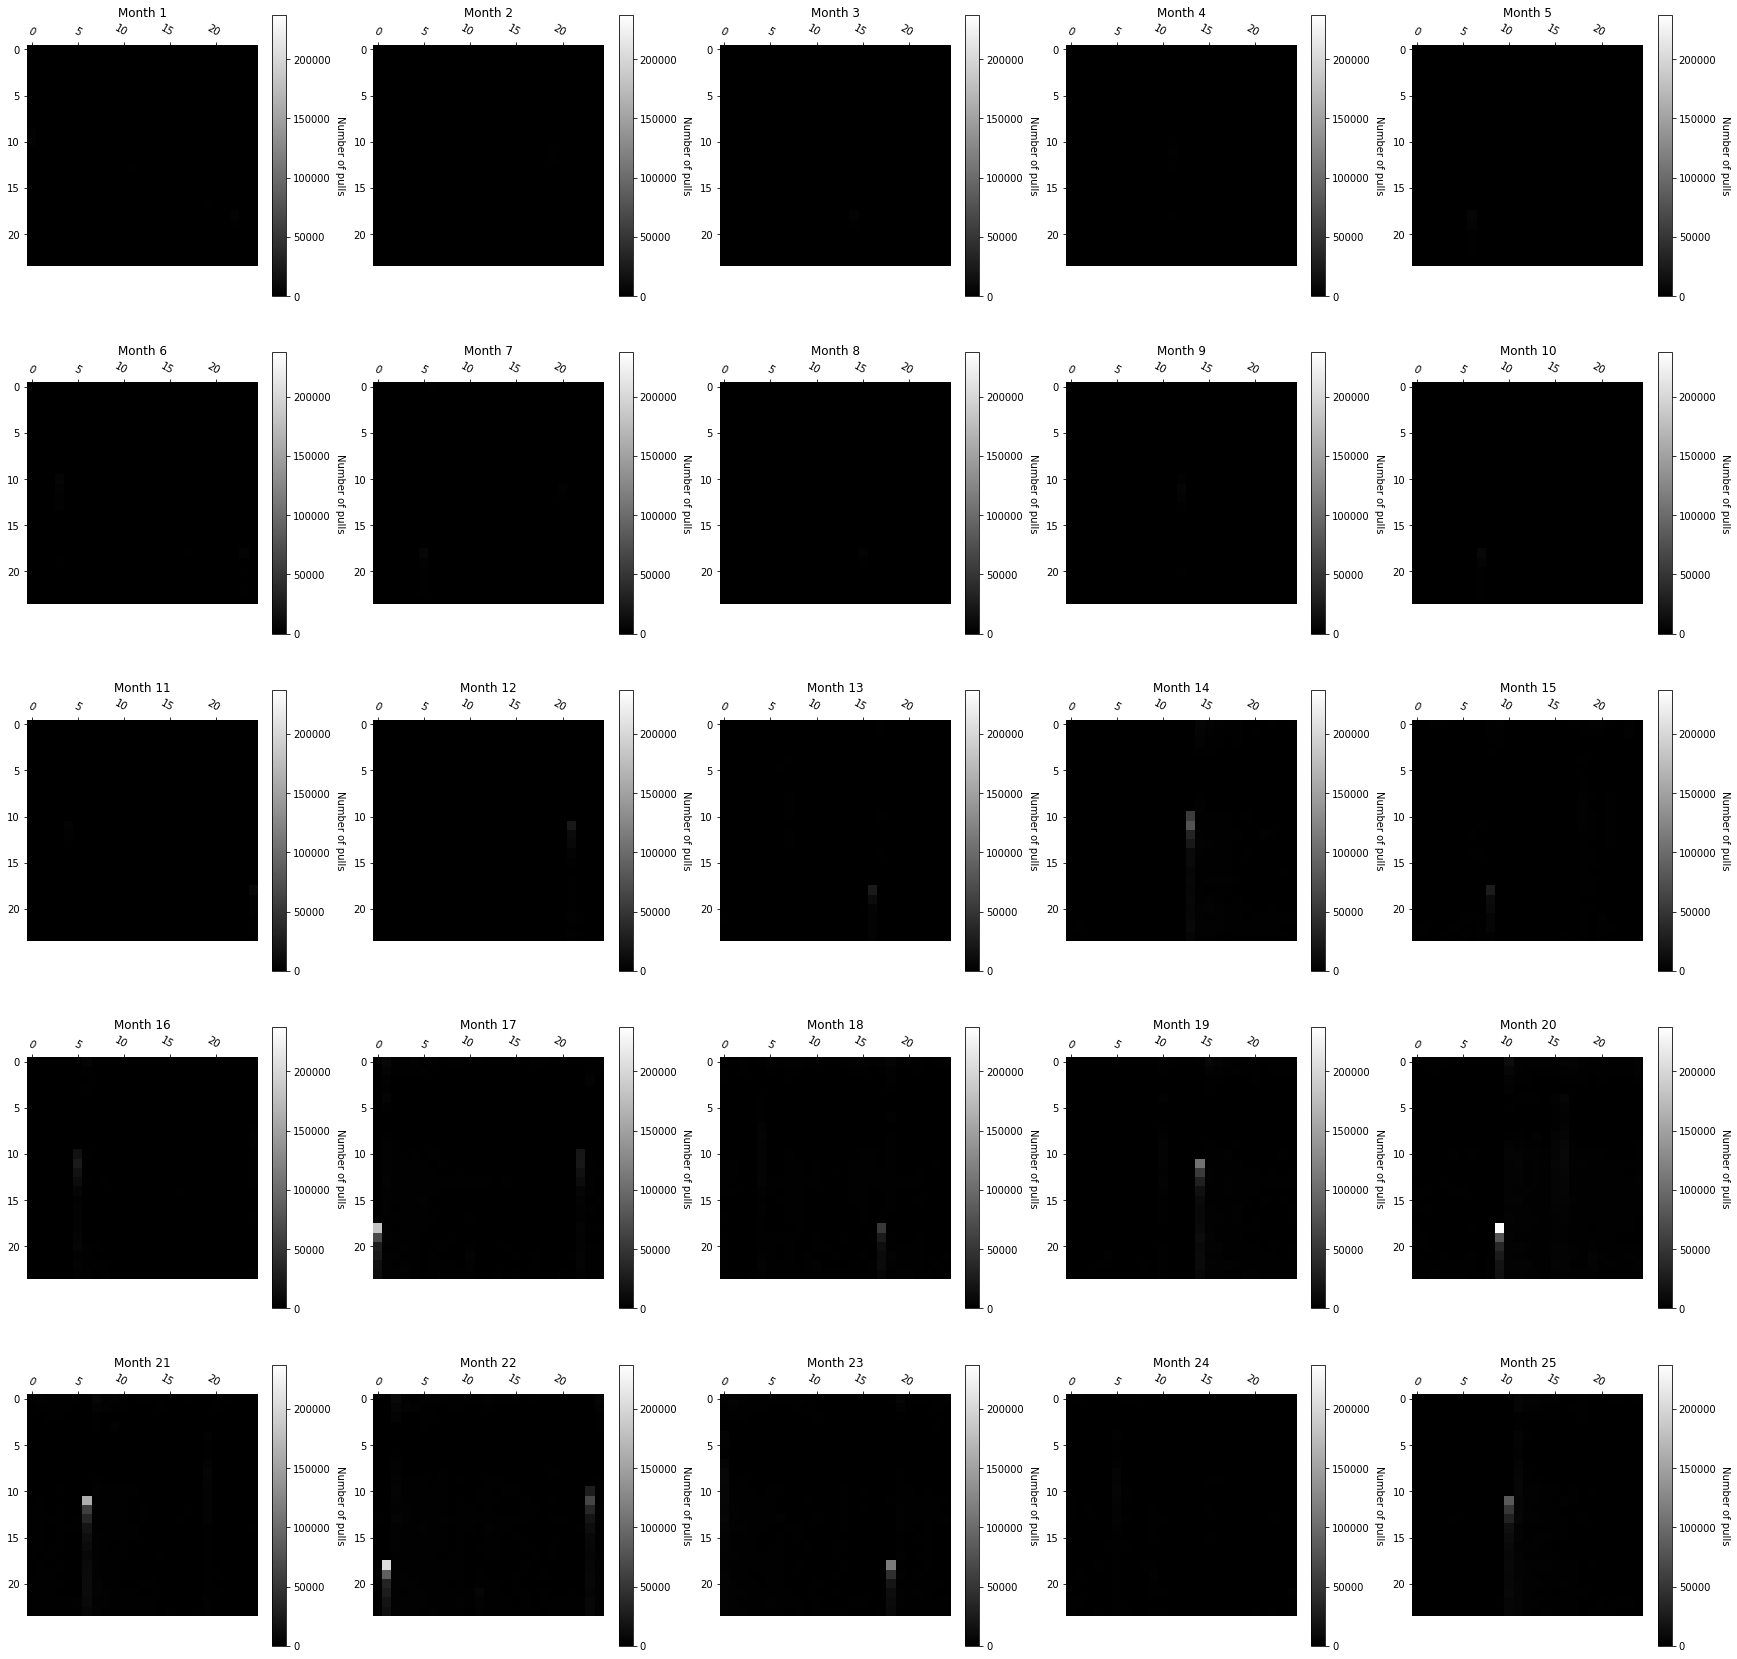

In [156]:
_, ax = plt.subplots(5, 5, figsize=(30, 30))
dsr_heatmap(all_total, ax, "Number of pulls")


### 5-star


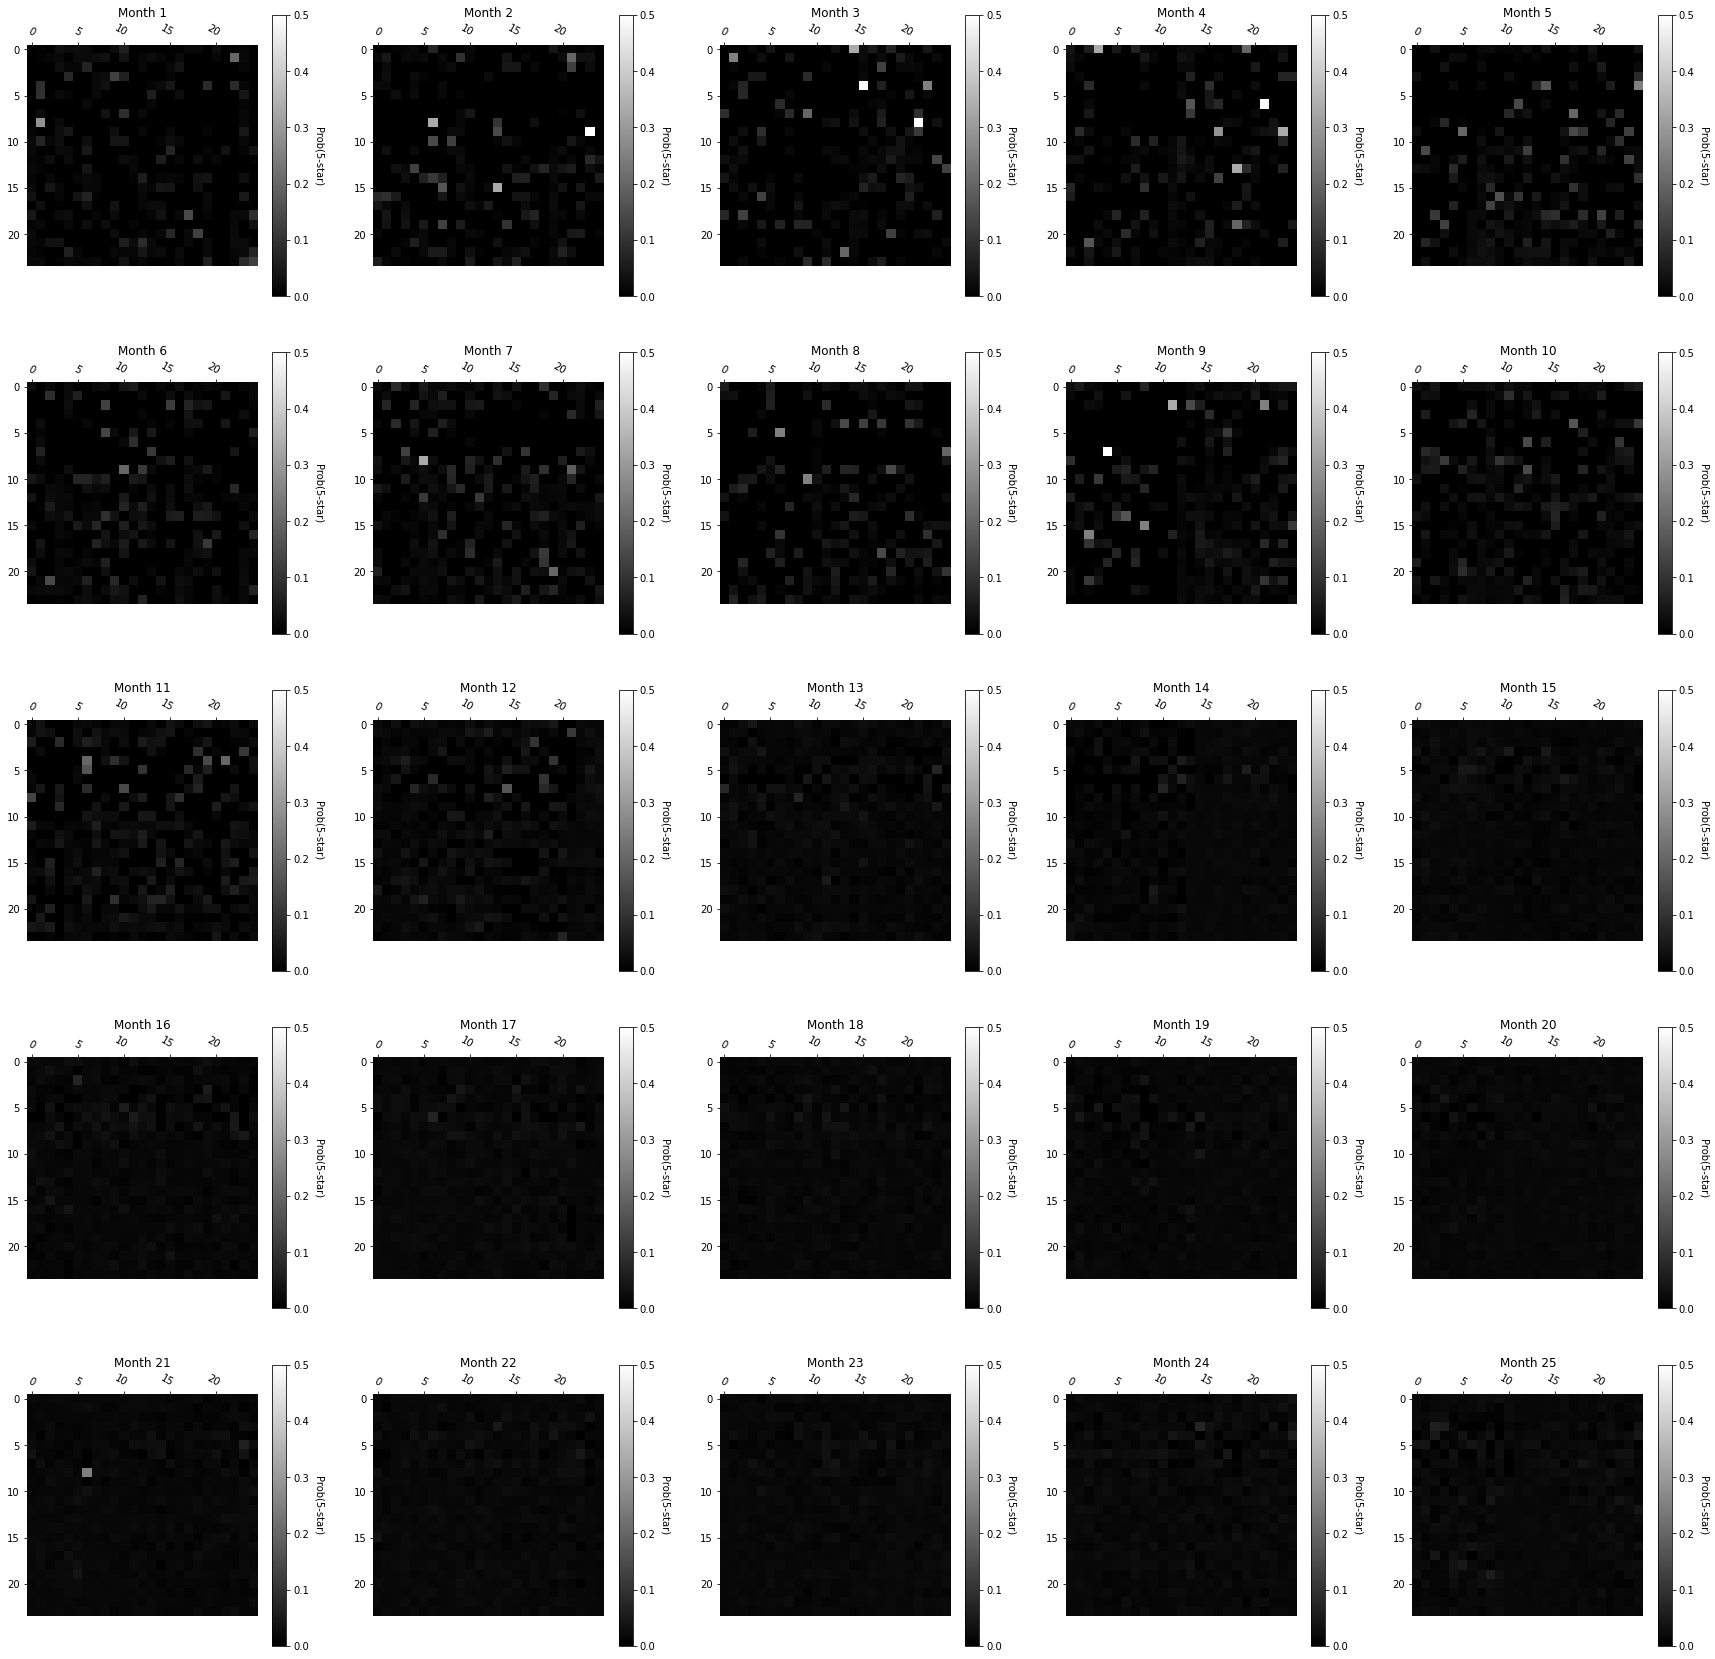

In [157]:
_, ax = plt.subplots(5, 5, figsize=(30, 30))
dsr_heatmap(all_fives, ax, "Prob(5-star)")


### 4-star


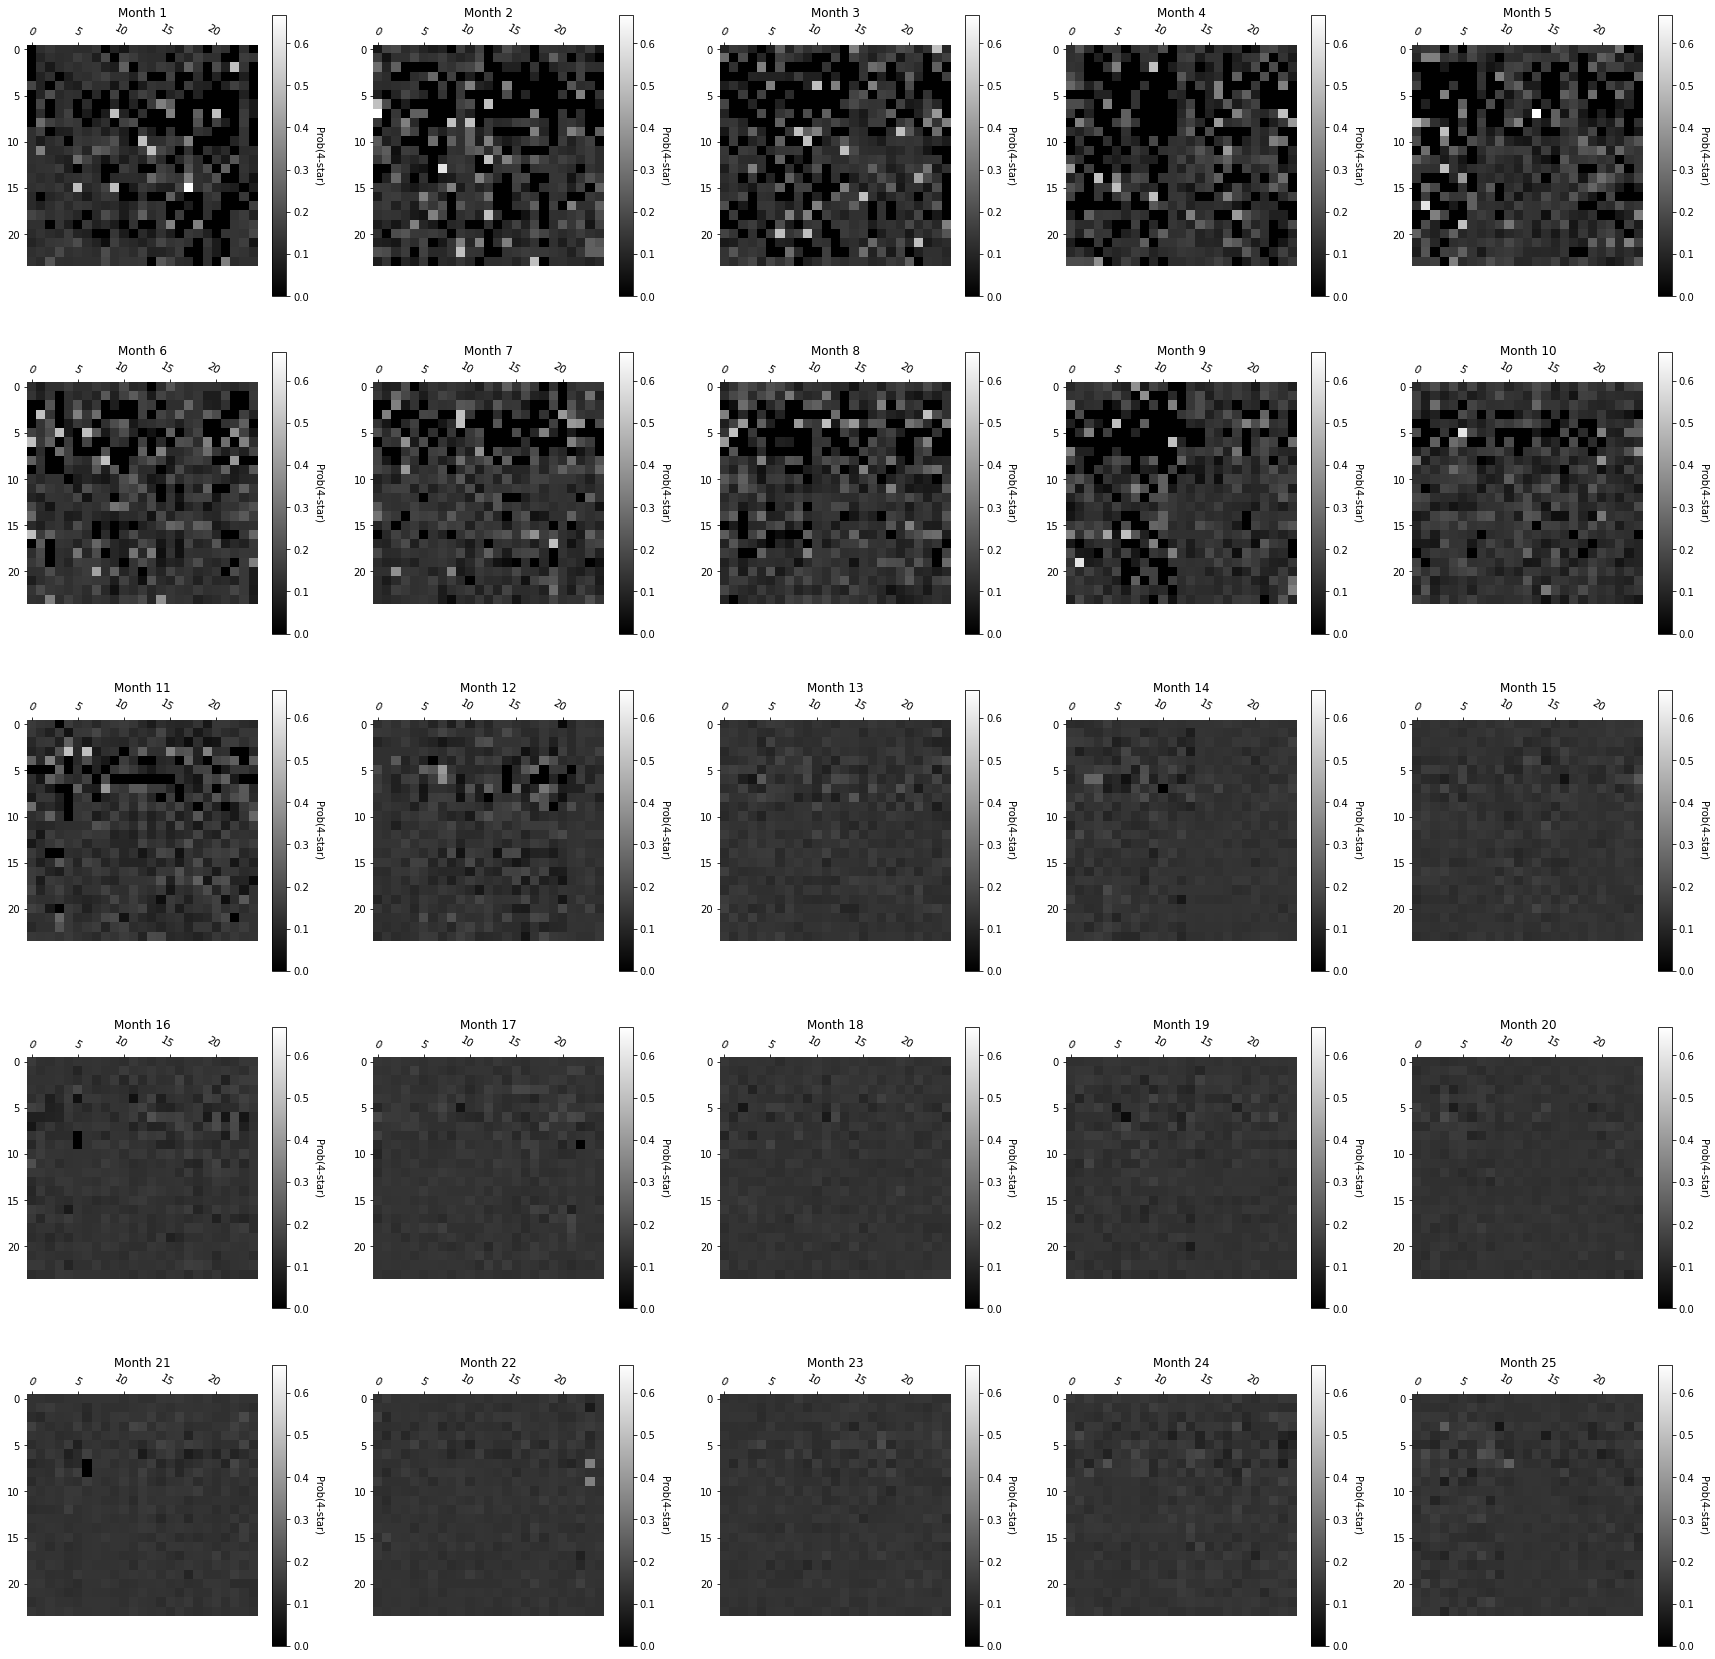

In [158]:
_, ax = plt.subplots(5, 5, figsize=(30, 30))
dsr_heatmap(all_fours, ax, "Prob(4-star)")


# Second Try: _Separated by Banner_

One of the patterns seen is that the probability seems to become more and more uniform as time goes on.
Thus, we are going to ignore the *"combined"* grouping, meaning that we will ignore the day-of-X groupings
in the following attempt(s).